## RegNetY_800MF Copy Notebook

Copy of other RegNetY_800MF nb, adapted model to generate submission compatible notebooks. To test why new notebook can't properly train models.

In [13]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import regnet_y_800mf, RegNet_Y_800MF_Weights
from torchvision import transforms
from IPython.display import Audio
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import torch.nn.functional as F
from tqdm import tqdm

import copy
import random
import glob
import os
import time

import sys
sys.path.append("..")
import utils

In [14]:
RANDOM_SEED = 21

# Set seed for experiment reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [15]:
is_in_kaggle_env = utils.get_is_in_kaggle_env()

data_path = '/kaggle/input/birdclef-2023' if is_in_kaggle_env else '../data'

device = 'cpu' if is_in_kaggle_env else utils.determine_device()

if not is_in_kaggle_env and not os.path.exists('../data'):
    print("Downloading data...")
    !kaggle competitions download -c 'birdclef-2023'
    !mkdir ../data
    !unzip -q birdclef-2023.zip -d ../data
    !rm birdclef-2023.zip

df_metadata_csv = pd.read_csv(f"{data_path}/train_metadata.csv")

audio_data_dir = f"{data_path}/train_audio/"

We are running code on Localhost
We are using device: mps


In [16]:
# Rows with 1 sample: copy twice, rows with 2 samples: copy once
# This is to ensure that stratified sampling for train/valid/test splits works correctly
def ensure_min_two_samples(df_metadata_csv):
    class_counts = df_metadata_csv["primary_label"].value_counts()

    one_sample_rows = df_metadata_csv[df_metadata_csv["primary_label"].isin(class_counts[class_counts == 1].index)]
    print(f"Number of rows with 1 sample: {len(one_sample_rows)}")
    if len(one_sample_rows) > 0:
        df_metadata_csv = pd.concat([df_metadata_csv, one_sample_rows, one_sample_rows], ignore_index=True)
    
    two_sample_rows = df_metadata_csv[df_metadata_csv["primary_label"].isin(class_counts[class_counts == 2].index)]
    print(f"Number of rows with 2 samples: {len(two_sample_rows)}")
    if len(two_sample_rows) > 0:
        df_metadata_csv = pd.concat([df_metadata_csv, two_sample_rows], ignore_index=True)

    return df_metadata_csv

df_metadata_csv = ensure_min_two_samples(df_metadata_csv)

# Run again to verify
df_metadata_csv = ensure_min_two_samples(df_metadata_csv)

Number of rows with 1 sample: 7
Number of rows with 2 samples: 6
Number of rows with 1 sample: 0
Number of rows with 2 samples: 0


In [17]:
unique_classes = df_metadata_csv.primary_label.unique()
print(f"Number of classes: {len(unique_classes)}")

Number of classes: 264


In [18]:
class BirdClef23Dataset(Dataset):
    def __init__(self, df, audio_data_dir, label_encoder, seconds, n_mels, device, pad_method = 'wrap'):
        self.df = df
        self.audio_data_dir = audio_data_dir
        self.label_encoder = label_encoder
        self.seconds = seconds
        self.n_mels = n_mels
        self.device = device
        self.pad_method = pad_method

    def __getitem__(self, index):
        audio_path = os.path.join(self.audio_data_dir, self.df.iloc[index, 11])
        audio_numpy, audio_sr = librosa.load(audio_path, sr=32000)

        if audio_sr != 32000:
            raise ValueError(f"Sample rate is not 32000, it is {audio_sr} for {audio_path}")

        # Increase audio length if below {seconds} by padding
        if audio_numpy.shape[0] < 32000 * self.seconds:
            padding_needed = int(32000 * self.seconds - audio_numpy.shape[0])
            
            pad_width = (0, padding_needed)
            
            # wrap means copy the audio until the length is reached
            if self.pad_method in ['wrap', 'wrap_double_reflect']:
                audio_numpy = np.pad(audio_numpy, pad_width, 'wrap')

            # constant means pad with constant value, here 0 --> 1-2% less accuracy
            if self.pad_method == 'constant_zero':
                audio_numpy = np.pad(audio_numpy, pad_width, 'constant', constant_values=0)

            # reflect means the vector mirrored
            if self.pad_method == 'reflect':
                audio_numpy = np.pad(audio_numpy, pad_width, 'reflect')

        # Truncate audio length if above {seconds}
        if audio_numpy.shape[0] > 32000 * self.seconds:
            # audio_numpy = audio_numpy[:32000 * self.seconds]
            
            max_start_idx = audio_numpy.shape[0] - (32000 * self.seconds)
            start_idx = np.random.randint(0, max_start_idx)
            audio_numpy = audio_numpy[start_idx:start_idx + (32000 * self.seconds)]

        # Create a mirrored version of the audio_numpy array and concatenate it
        if self.pad_method == 'wrap_double_reflect':
            mirrored_audio_numpy = audio_numpy[::-1]
            audio_numpy = np.concatenate((audio_numpy, mirrored_audio_numpy))

        # What is a mel-scaled spectrogram? https://www.youtube.com/watch?v=PYlr8ayHb4g
        # Compute mel-scaled spectrogram and convert to log scale (dB) https://librosa.org/doc/latest/generated/librosa.feature.melspectrogram.html
        mel_spectrogram = librosa.feature.melspectrogram(y=audio_numpy, sr=audio_sr, n_mels=self.n_mels)
        log_mel_spectrogram = librosa.amplitude_to_db(mel_spectrogram)
        log_mel_spectrogram_norm = utils.normalize_spectrogram(log_mel_spectrogram)

        audio_numpy = log_mel_spectrogram_norm.reshape((1, log_mel_spectrogram_norm.shape[0], log_mel_spectrogram_norm.shape[1]))
        
        audio_tensor = torch.from_numpy(audio_numpy).float().to(self.device)

        primary_label_raw = self.df.iloc[index, 0]
        primary_label = self.label_encoder.transform([primary_label_raw])[0]

        row_id = audio_path.split('/')[-1].split('.')[0]

        return row_id, audio_tensor, primary_label
    
    def __len__(self):
        return len(self.df)


def get_data_loader(dataset, batch_size=32, data_percentage=None, shuffle=False, pin_memory=False):
    if data_percentage is not None:
        data_len = int(len(dataset) * data_percentage)
        dataset, _ = random_split(dataset, [data_len, len(dataset) - data_len])

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)

    return data_loader


def split_df(df, primary_label='primary_label', percentages=[60, 20, 20]):
    """
    - Percentages: [train, valid, test]
    - Splits a dataframe into three dataframes (train, valid, test), stratified by primary_label
    - Also returns the class weights (based on the training set)
    """
    print(f"Splitting dataframe into train {percentages[0]}%, valid {percentages[1]}%, test {percentages[2]}%, stratified by {primary_label}")
    
    train_perc, valid_perc, test_perc = [perc / 100 for perc in percentages]
    train_valid_split = round(train_perc / (train_perc + valid_perc), 2)
    
    temp_df, test_df = train_test_split(df, test_size=test_perc, stratify=df[primary_label], random_state=RANDOM_SEED)
    
    train_df, valid_df = train_test_split(temp_df, test_size=1-train_valid_split, stratify=temp_df[primary_label], random_state=RANDOM_SEED)

    classes = np.unique(train_df[primary_label])
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_df[primary_label])

    return train_df, valid_df, test_df, class_weights


class RegnetCNN(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        # https://pytorch.org/vision/stable/models.html
        self.regnet = regnet_y_800mf(weights=RegNet_Y_800MF_Weights.DEFAULT)

        """
        Replace the stem to take 1 channel instead of 3. The original stem:
        RegnetCNN(
        (regnet): RegNet(
            (stem): SimpleStemIN(
            (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
        )"""
        self.regnet.stem = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
        )
        
        # Fine-tune the regnet classifier
        self.regnet.fc = nn.Sequential(
            nn.Linear(self.regnet.fc.in_features, 512),
            nn.BatchNorm1d(512),
            nn.PReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.PReLU(),
            nn.Linear(256, num_classes),
        )

        self.softmax = nn.Softmax(dim=1)
 
    def forward(self, x):
        logits = self.regnet(x)
        probas = self.softmax(logits)

        return logits, probas


def train(model, train_loader, valid_loader, loss_func, optimizer, num_epochs, validate_on_train, scheduler, device):
    minibatch_loss, train_acc_lst, valid_acc_lst, train_loss_lst, valid_loss_lst, best_valid_acc = [], [], [], [], [], 0.0
    
    for epoch in range(num_epochs):
        print(f"Starting epoch {epoch+1}/{num_epochs}")
        model.train()
        
        # use tqdm to show progress bar
        for row_id, audio_tensor, primary_label in tqdm(train_loader, total=len(train_loader), desc="Training batches"):

            features = audio_tensor.to(device)
            targets = primary_label.to(device)

            logits, probas = model(features)

            loss = loss_func(logits, targets)

            optimizer.zero_grad()
            
            loss.backward()

            minibatch_loss.append(loss.item())
            
            optimizer.step()
            
        train_acc, train_loss = validate(model, train_loader, loss_func) if validate_on_train else (torch.tensor(0.0), torch.tensor(0.0))
        train_acc_lst.append(train_acc)
        train_loss_lst.append(train_loss)

        valid_acc, valid_loss = validate(model, valid_loader, loss_func)
        valid_acc_lst.append(valid_acc)
        valid_loss_lst.append(valid_loss)

        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            print("Moving model to CPU and saving it ...")
            model_cpu = copy.deepcopy(model)
            model_cpu.to('cpu')
            torch.save(model_cpu.state_dict(), 'best_long_model.pt')

        if scheduler is not None:
            lr_before = optimizer.param_groups[0]['lr']
            scheduler.step(valid_loss)
            lr_after = optimizer.param_groups[0]['lr']
            if lr_before != lr_after:
                print(f"Learning rate changed from {lr_before} to {lr_after}")

        print(f"Finsished epoch {epoch+1}/{num_epochs}. Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Valid Accuracy: {valid_acc:.2f}%")
              
    return minibatch_loss, train_loss_lst, valid_loss_lst, train_acc_lst, valid_acc_lst


def validate(model, data_loader, loss_fn=F.cross_entropy):
    model.eval()
    
    num_examples, correct_pred, cross_entropy = 0.0, 0.0, 0.0

    with torch.no_grad():
        for row_id, audio_tensor, primary_label in tqdm(data_loader, total=len(data_loader), desc='Validation batches'):
            features = audio_tensor.to(device)
            targets = primary_label.to(device)

            logits, probas = model(features)
            cross_entropy += loss_fn(logits, targets)

            _, predicted_labels = torch.max(probas, 1)
            num_examples += targets.size(0)

            correct_pred += (predicted_labels == targets).sum()

    accuracy = correct_pred / num_examples * 100
    loss = cross_entropy / num_examples
    return accuracy, loss


# --- training
print('Creating label encoder...')
label_encoder = LabelEncoder()
label_encoder.fit(list(unique_classes))
joblib.dump(label_encoder, 'label_encoder.joblib')

train_df, valid_df, test_df, class_weights = split_df(df_metadata_csv)

seconds = 5 # 24 is the median - but 20 has better results
batch_size = 64
data_percentage = 1 # 1 means 100% of the data
num_epochs = 20
n_mels = 128 # 128 is the default value in librosa
learning_rate = 0.00008
# device = 'cpu'
pad_method = 'wrap' # wrap, constant_zero, reflect, wrap_double_reflect

pin_memory = True # https://discuss.pytorch.org/t/when-to-set-pin-memory-to-true/19723/6
validate_on_train = True

train_dataset = BirdClef23Dataset(train_df, audio_data_dir, label_encoder, seconds, n_mels, device, pad_method=pad_method)
valid_dataset = BirdClef23Dataset(valid_df, audio_data_dir, label_encoder, seconds, n_mels, device, pad_method=pad_method)
# test_dataset = BirdClef23Dataset(test_df, audio_data_dir, label_encoder, seconds, n_mels, device, pad_method=pad_method)

train_loader = get_data_loader(train_dataset, batch_size, data_percentage, shuffle=True, pin_memory=pin_memory)
valid_loader = get_data_loader(valid_dataset, batch_size, data_percentage, shuffle=False, pin_memory=pin_memory)
# test_loader = get_data_loader(test_dataset, batch_size, data_percentage, shuffle=False, pin_memory=pin_memory)

model = RegnetCNN(num_classes=len(unique_classes)).to(device)
print(f"Initialized model {model._get_name()}, trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
# print(model)

loss_function = torch.nn.CrossEntropyLoss(weight=torch.from_numpy(class_weights).float().to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
# scheduler = None

print(f"Seconds: {seconds}, batch_size: {batch_size}, data_percentage: {data_percentage}, num_epochs: {num_epochs}, n_mels: {n_mels}, learning_rate: {learning_rate}, pin_memory: {pin_memory}, validate_on_train: {validate_on_train}, device: {device}, pad_method: {pad_method}")

minibatch_loss, train_loss_lst, valid_loss_lst, train_acc_lst, valid_acc_lst = train(model, train_loader, valid_loader, loss_function, optimizer, num_epochs, validate_on_train, scheduler, device)

Creating label encoder...
Splitting dataframe into train 60%, valid 20%, test 20%, stratified by primary_label
Initialized model RegnetCNN, trainable parameters: 6249570
Seconds: 5, batch_size: 64, data_percentage: 1, num_epochs: 20, n_mels: 128, learning_rate: 8e-05, pin_memory: True, validate_on_train: True, device: mps, pad_method: wrap
Starting epoch 1/20


Validation batches: 100%|██████████| 53/53 [01:45<00:00,  1.98s/it]


Moving model to CPU and saving it ...
Finsished epoch 1/20. Train Loss: 0.0862, Valid Loss: 0.0868, Train Accuracy: 1.24%, Valid Accuracy: 1.06%
Starting epoch 2/20


Validation batches: 100%|██████████| 53/53 [01:48<00:00,  2.05s/it]


Moving model to CPU and saving it ...
Finsished epoch 2/20. Train Loss: 0.0826, Valid Loss: 0.0850, Train Accuracy: 2.91%, Valid Accuracy: 2.68%
Starting epoch 3/20


Validation batches: 100%|██████████| 53/53 [01:45<00:00,  2.00s/it]


Moving model to CPU and saving it ...
Finsished epoch 3/20. Train Loss: 0.0792, Valid Loss: 0.0826, Train Accuracy: 5.51%, Valid Accuracy: 3.92%
Starting epoch 4/20


Validation batches: 100%|██████████| 53/53 [01:46<00:00,  2.02s/it]


Moving model to CPU and saving it ...
Finsished epoch 4/20. Train Loss: 0.0765, Valid Loss: 0.0803, Train Accuracy: 8.02%, Valid Accuracy: 6.75%
Starting epoch 5/20


Validation batches: 100%|██████████| 53/53 [01:46<00:00,  2.01s/it]


Moving model to CPU and saving it ...
Finsished epoch 5/20. Train Loss: 0.0721, Valid Loss: 0.0777, Train Accuracy: 10.64%, Valid Accuracy: 7.96%
Starting epoch 6/20


Validation batches: 100%|██████████| 53/53 [01:46<00:00,  2.01s/it]


Moving model to CPU and saving it ...
Finsished epoch 6/20. Train Loss: 0.0691, Valid Loss: 0.0757, Train Accuracy: 13.63%, Valid Accuracy: 10.11%
Starting epoch 7/20


Validation batches: 100%|██████████| 53/53 [01:47<00:00,  2.03s/it]


Moving model to CPU and saving it ...
Finsished epoch 7/20. Train Loss: 0.0652, Valid Loss: 0.0730, Train Accuracy: 16.56%, Valid Accuracy: 13.09%
Starting epoch 8/20


Validation batches: 100%|██████████| 53/53 [01:47<00:00,  2.02s/it]


Finsished epoch 8/20. Train Loss: 0.0878, Valid Loss: 0.0880, Train Accuracy: 2.69%, Valid Accuracy: 2.83%
Starting epoch 9/20


Validation batches: 100%|██████████| 53/53 [01:46<00:00,  2.02s/it]


Moving model to CPU and saving it ...
Finsished epoch 9/20. Train Loss: 0.0575, Valid Loss: 0.0691, Train Accuracy: 22.81%, Valid Accuracy: 16.83%
Starting epoch 10/20


Validation batches: 100%|██████████| 53/53 [01:46<00:00,  2.02s/it]


Moving model to CPU and saving it ...
Finsished epoch 10/20. Train Loss: 0.0576, Valid Loss: 0.0677, Train Accuracy: 24.43%, Valid Accuracy: 17.72%
Starting epoch 11/20


Validation batches: 100%|██████████| 53/53 [01:47<00:00,  2.02s/it]


Moving model to CPU and saving it ...
Finsished epoch 11/20. Train Loss: 0.0516, Valid Loss: 0.0649, Train Accuracy: 27.91%, Valid Accuracy: 20.99%
Starting epoch 12/20


Validation batches: 100%|██████████| 53/53 [01:46<00:00,  2.02s/it]


Moving model to CPU and saving it ...
Finsished epoch 12/20. Train Loss: 0.0482, Valid Loss: 0.0639, Train Accuracy: 31.12%, Valid Accuracy: 22.35%
Starting epoch 13/20


Validation batches: 100%|██████████| 53/53 [01:46<00:00,  2.02s/it]


Finsished epoch 13/20. Train Loss: 0.0886, Valid Loss: 0.0887, Train Accuracy: 2.94%, Valid Accuracy: 2.89%
Starting epoch 14/20


Validation batches: 100%|██████████| 53/53 [01:47<00:00,  2.02s/it]


Finsished epoch 14/20. Train Loss: 0.0826, Valid Loss: 0.0838, Train Accuracy: 5.40%, Valid Accuracy: 5.31%
Starting epoch 15/20


Validation batches: 100%|██████████| 53/53 [01:47<00:00,  2.03s/it]


Moving model to CPU and saving it ...
Finsished epoch 15/20. Train Loss: 0.0392, Valid Loss: 0.0597, Train Accuracy: 40.05%, Valid Accuracy: 28.57%
Starting epoch 16/20


Validation batches: 100%|██████████| 53/53 [01:47<00:00,  2.02s/it]


Moving model to CPU and saving it ...
Finsished epoch 16/20. Train Loss: 0.0377, Valid Loss: 0.0591, Train Accuracy: 41.96%, Valid Accuracy: 29.66%
Starting epoch 17/20


Validation batches: 100%|██████████| 53/53 [01:46<00:00,  2.02s/it]


Moving model to CPU and saving it ...
Finsished epoch 17/20. Train Loss: 0.0361, Valid Loss: 0.0570, Train Accuracy: 44.91%, Valid Accuracy: 33.23%
Starting epoch 18/20


Validation batches: 100%|██████████| 53/53 [01:47<00:00,  2.03s/it]


Finsished epoch 18/20. Train Loss: 0.0530, Valid Loss: 0.0642, Train Accuracy: 35.25%, Valid Accuracy: 27.42%
Starting epoch 19/20


Validation batches: 100%|██████████| 53/53 [01:47<00:00,  2.02s/it]


Moving model to CPU and saving it ...
Finsished epoch 19/20. Train Loss: 0.0317, Valid Loss: 0.0553, Train Accuracy: 50.11%, Valid Accuracy: 35.79%
Starting epoch 20/20


Validation batches: 100%|██████████| 53/53 [01:47<00:00,  2.03s/it]

Finsished epoch 20/20. Train Loss: 0.0461, Valid Loss: 0.0623, Train Accuracy: 38.31%, Valid Accuracy: 29.45%


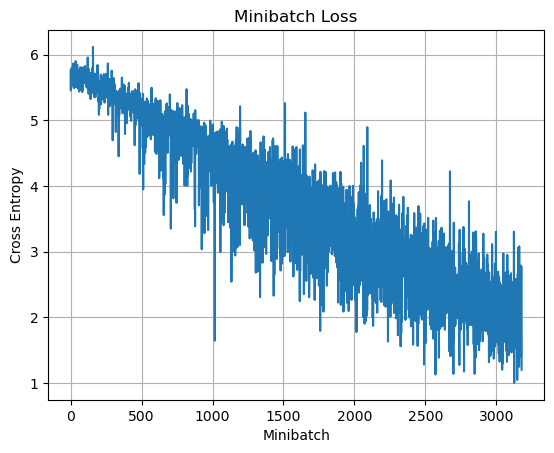

In [19]:
utils.plot_minibatch_loss(minibatch_loss)

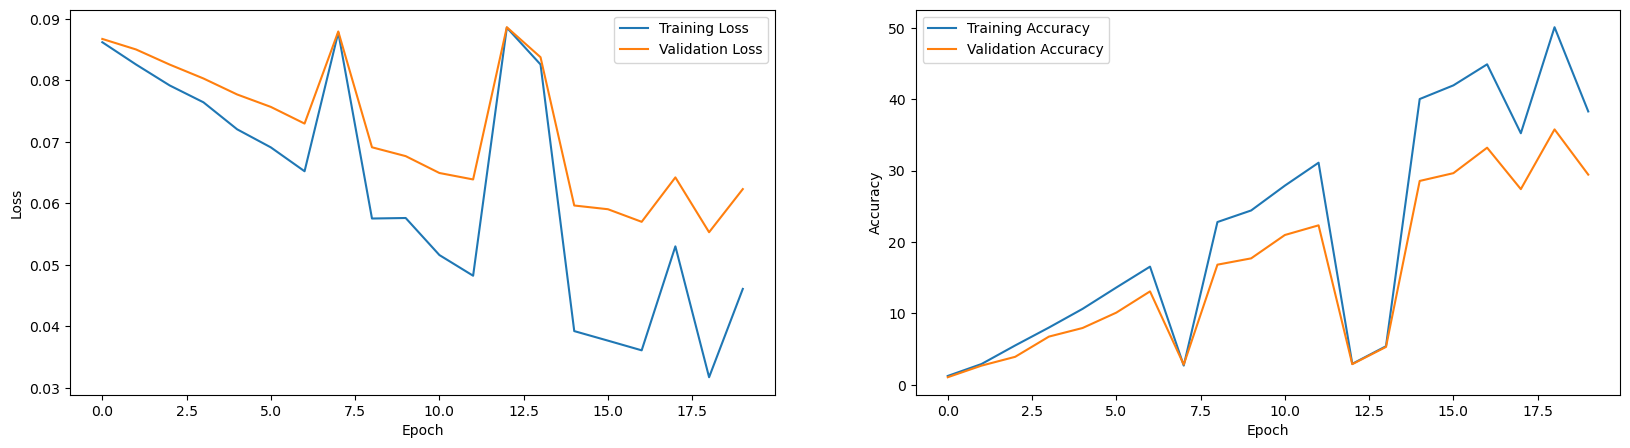

In [20]:
utils.plot_train_and_valid_loss_and_accuracy(train_loss_lst, valid_loss_lst, train_acc_lst, valid_acc_lst)